In [2]:
import SimpleITK as sitk

import numpy as np
import os
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt

from downloaddata import fetch_data as fdata

OUTPUT_DIR = 'output'

image_viewer = sitk.ImageViewer()

# Funciones

In [3]:
def histo(img):
    arr = sitk.GetArrayFromImage(img)
    fig = plt.figure(figsize = (7,5))
    ax = fig.gca()
    ax.hist(arr.flatten(), bins = 255)
    plt.show(fig)

def plotImg(img, color = 'gray'):
    arr = sitk.GetArrayFromImage(img)
    plt.imshow(arr, cmap = color)

# Cargar imagenes

In [4]:
image_viewer.SetApplication('/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP')

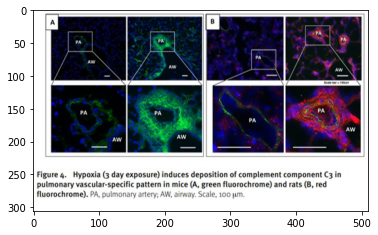

In [7]:
img = sitk.ReadImage("data/SimpleITK.jpg")
plotImg(img)

In [ ]:
image_viewer.Execute(img)

**Binario nueva manera**

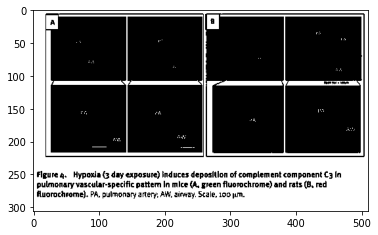

In [10]:
from skimage.color import rgb2gray
grayscale = sitk.GetImageFromArray(rgb2gray(sitk.GetArrayViewFromImage(img)))
grayscale *=255
binImg = grayscale > 200
plotImg(binImg, 'gray')

# FILTROS

In [11]:
path = 'images/rx/00008397_005.png'
rx = sitk.ReadImage(path)
plotImg(rx)

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "images/rx/00008397_005.png" does not exist.

In [ ]:
aa=sitk.Threshold(rx,70,150,2)
plotImg(aa)

In [6]:
aa_b=sitk.BinaryThreshold(rx,70,150,1,0)
plotImg(aa_b)

NameError: name 'rx' is not defined

In [ ]:
?sitk.

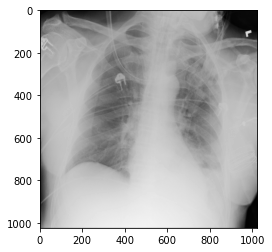

In [136]:
plotImg(data[0])

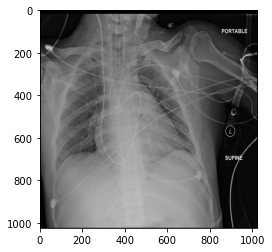

In [138]:
plotImg(data[2])

In [134]:
?sitk.HistogramMatching

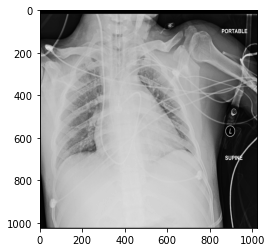

In [140]:
a = sitk.HistogramMatching(data[2], data[0])
plotImg(a)

# CT

In [7]:
path = 'images/10052Z_INSP_B31f_370_NJC_COPD2/10052Z_INSP_B31f_370_NJC_COPD2_signalNoiseStabilization.nrrd'
ct = sitk.ReadImage(path)
ct.GetSize()

(512, 512, 701)

In [108]:
image_viewer.Execute(ct)

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sCAL: invalid unit


In [9]:
ctArr = sitk.GetArrayFromImage(ct)
ctArr.shape

(701, 512, 512)

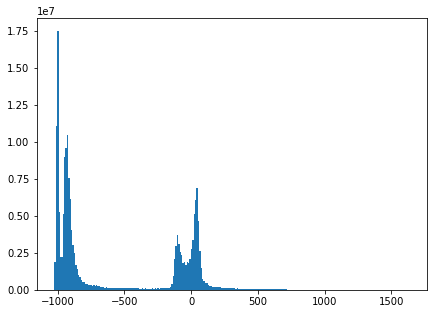

Return code : 0


In [10]:
histo(ct)

## Binario

In [11]:
ctBin = ct > -500 and ct < 500

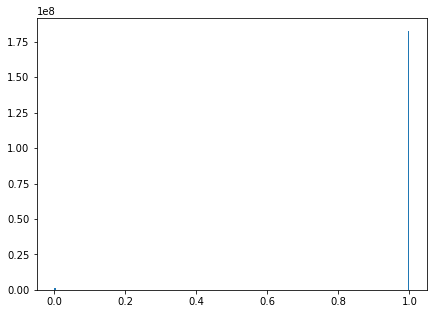

In [12]:
histo(ctBin)

In [141]:
sitk.WriteImage(ctBin, os.path.join(OUTPUT_DIR, 'ctmask.nrrd'))

Return code : 0


In [13]:
image_viewer.Execute(ctBin)

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sCAL: invalid unit
Return code : 0


**Cogemos pulmon**

In [14]:
ctBin = ct < -600

In [15]:
image_viewer.Execute(ctBin)

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sCAL: invalid unit
Return code : 0


# RX

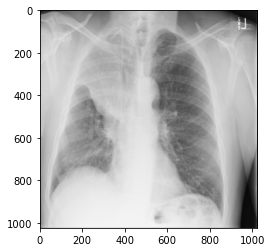

In [124]:
path = 'images/rx/00008397_005.png'
rx = sitk.ReadImage(path)
plotImg(rx)

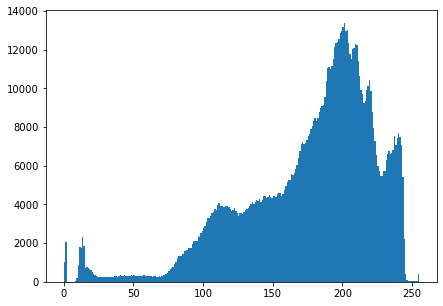

In [17]:
histo(rx)

In [18]:
rx.GetSize()

(1024, 1024)

Elimino el aire puro

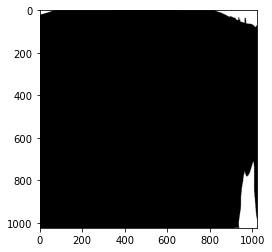

In [125]:
noOutsite = rx <70
plotImg(noOutsite)

In [20]:
rxAr = sitk.GetArrayFromImage(rx)
noAr = sitk.GetArrayFromImage(noOutsite)
rxAr[noAr == 1] = 255

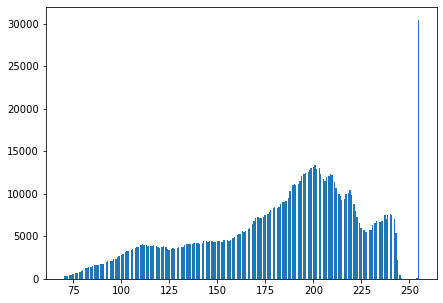

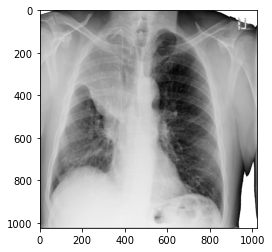

In [21]:
rx = sitk.GetImageFromArray(rxAr)
histo(rx)
plotImg(rx, 'gray')

Elijo el threshold para ser pulmon. Cojo la mitad inferior de los pixeles.

Dentro de esa mitad hago dos opciones
- Me quedo con su intervalo de confianza de la media al 999% 
- Me quedo con los valores dentro de su rango intercuartilico

In [52]:
import scipy.stats as st

In [68]:
def extract_low_mean_range(imgArr):
    vector = np.concatenate(imgArr)
    vector = vector[vector < np.mean(vector)]
    rango = st.t.interval(alpha=0.999, df=len(vector)-1, loc=np.mean(vector), scale=st.sem(vector))
    return rango

In [78]:
def extract_outliers(imgArr, quartile1, quartile2): 
    vector = np.concatenate(imgArr)
    vector = vector[vector < np.mean(vector)]
    quart = np.percentile(vector, [quartile1, quartile2])
    return quart

Pruebo como queda con los rangos intercuartilicos

In [79]:
rango = extract_outliers(rxAr, 45, 55)

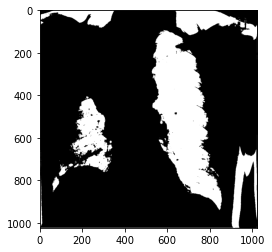

In [80]:
pulmon = rx > rango[0] and rx < rango[1]
plotImg(pulmon, 'gray')

Pruebo como queda con el intervalo de confianza de la media

In [81]:
rango = extract_low_mean_range(rxAr)

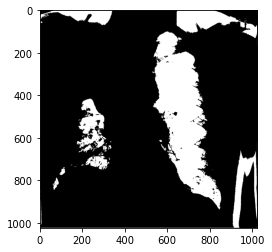

In [82]:
pulmon = rx > rango[0] and rx < rango[1]
plotImg(pulmon, 'gray')

Pruebo como queda solo eligiendo yo el threshold

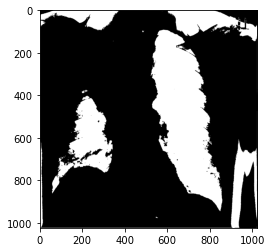

In [56]:
pulmon = rx < 160
plotImg(pulmon, 'gray')

In [1]:
OUTPUT_DIR = 'output'
pulmon*=255
sitk.WriteImage(pulmon, os.path.join(OUTPUT_DIR, 'binaryRx.png'))

NameError: name 'pulmon' is not defined

## Filtro

In [28]:
import SimpleITK as sitk
import numpy as np
import os

import gui

from utilities import parameter_space_regular_grid_sampling, similarity3D_parameter_space_regular_sampling, eul2quat

In [32]:
import re
from os import listdir
from os.path import isfile, join

In [34]:
mypath = 'images/rx'
# Recojo todos los files en mypath
rxFiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# Me quedo con aquellos que contienen png
rxFiles = [file for file in rxFiles if re.search('png', file) is not None]
# Cargo todas las imagenes de esas files en un vector
data = [sitk.ReadImage(os.path.join('images/rx', path)) for path in rxFiles]

In [35]:
# Funcion copiada
def disp_images(images, fig_size, wl_list=None):
    if images[0].GetDimension()==2:
      gui.multi_image_display2D(image_list=images, figure_size=fig_size, window_level_list=wl_list)
    else:
      gui.MultiImageDisplay(image_list=images, figure_size=fig_size, window_level_list=wl_list)

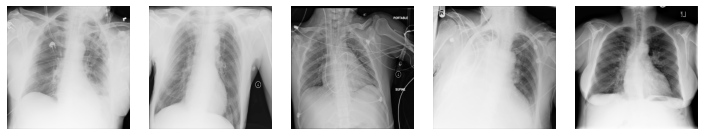

In [36]:
disp_images(data[0:5], fig_size=(10,2))

In [37]:
# Funcion copiada que se supone quita los bordes de las imagenes
def threshold_based_crop_and_bg_median(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box and compute the background 
    median intensity.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.
        Background median intensity value.
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    bin_image = sitk.OtsuThreshold(image, inside_value, outside_value)

    # Get the median background intensity
    label_intensity_stats_filter = sitk.LabelIntensityStatisticsImageFilter()
    label_intensity_stats_filter.SetBackgroundValue(outside_value)
    label_intensity_stats_filter.Execute(bin_image,image)
    bg_median = label_intensity_stats_filter.GetMedian(inside_value)
    
    # Get the bounding box of the anatomy
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()    
    label_shape_filter.Execute(bin_image)
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return bg_median, sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])


bg_medians, modified_data = zip(*[threshold_based_crop_and_bg_median(img) for img in data[0:10]])

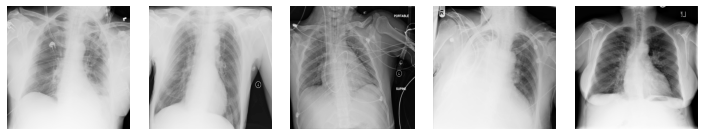

In [38]:
disp_images(modified_data[0:5], fig_size=(10,2))

## Trabajo con todas las imagenes

In [96]:
# Funcion para cargar la imagen, aplicarle el filtro y guardarla

def imgBin(path, threshold = False, thr = 160):
    # Creo el path de lectura
    print(path)
    readPath = os.path.join (mypath,path)
    # Leo la iamgen
    rx = sitk.ReadImage(readPath)
    # Aplico el filtro
    if threshold:
        pulmon = rx < thr
    else:
        rango = extract_outliers(sitk.GetArrayFromImage(rx), 20, 80)
        pulmon = rx > rango[0] and rx < rango[1]
    # Lo paso a 255
    pulmon*=255
    # Guardo la imagen
    sitk.WriteImage(pulmon, os.path.join(OUTPUT_DIR, path))
    # La devuelvo
    return(pulmon)

In [97]:
rxBin160 = [imgBin(path, True, 130) for path in rxFiles[0:10]]

00008081_013.png
00007256_003.png
00007185_019.png
00007683_004.png
00009001_007.png
00007345_000.png
00006642_037.png
00007355_000.png
00008847_000.png
00007526_002.png


In [106]:
rxBin = [imgBin(path) for path in rxFiles[0:10]]

00008081_013.png
00007256_003.png
00007185_019.png
00007683_004.png
00009001_007.png
00007345_000.png
00006642_037.png
00007355_000.png
00008847_000.png
00007526_002.png


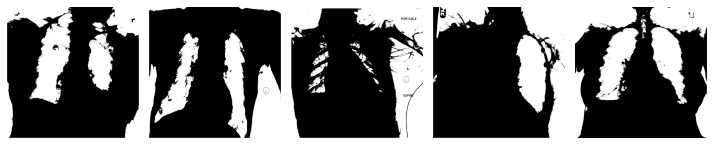

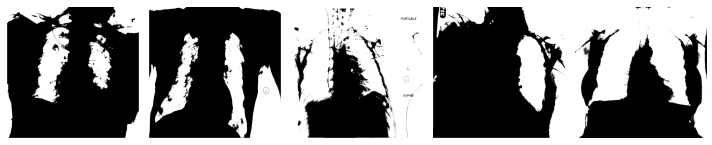

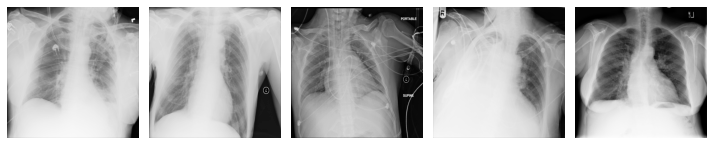

In [107]:
disp_images(rxBin[0:5], fig_size=(10,3))
disp_images(rxBin160[0:5], fig_size=(10,3))
disp_images(data[0:5], fig_size=(10,3))